### This notebook should create a csv with the Elon Musk Tweets, containg btc releated info, sentimental analisys scores and the btc prices indexed by date

In [3]:
import glob
import os
import pandas as pd
import re
import numpy as np
import nltk
import string
from sklearn.preprocessing import minmax_scale
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/prbpedro/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Read data for pre processing

base_path_to_csv = os.path.join(os.getcwd() + '/eltweets/*.csv')
csv_list = glob.glob(base_path_to_csv)

df_list = [pd.read_csv(csv, index_col='id') for csv in csv_list]
df = pd.concat(df_list)
df = df.reset_index().drop_duplicates(subset='id', keep='first').set_index('id')

In [5]:
# Normalizing tweets to sentimental analisys

df['full_text'] = df['full_text'].astype('unicode')
remove_rt = lambda x: re.sub('RT @\w+: ', ' ', x)
remove_users_ref = lambda x: re.sub("@[A-Za-z0-9]+","",x)
remove_links = lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)
remove_hashtags_underlines = lambda x: x.replace("#", "").replace("_", " ")

df['full_text'] = df['full_text'].map(remove_rt).map(remove_users_ref).map(remove_links).map(remove_hashtags_underlines)
df['full_text'] = df['full_text'].str.lower()
df = df[df['full_text'].str.contains("bitcoin|btc|etherum|eth | eth|crypto|doge")]

df['full_text'] = df['full_text'].str.replace('&amp;', 'and')
df['full_text'] = df['full_text'].str.replace('&', 'and')
df['full_text'] = df['full_text'].str.replace('💔', 'broke my heart')
df['full_text'] = df['full_text'].str.replace('🤣', 'laughing ')
df['full_text'] = df['full_text'].str.replace('🎶', '')
df['full_text'] = df['full_text'].str.replace("it’s", 'it is')
df['full_text'] = df['full_text'].str.replace("don’t", 'do not')
df['full_text'] = df['full_text'].str.replace("can’t", 'can not')
df['full_text'] = df['full_text'].str.replace("won’t", 'will not')
df['full_text'] = df['full_text'].str.replace("people’s", 'people')
df['full_text'] = df['full_text'].str.replace("people’s", 'people')
df['full_text'] = df['full_text'].str.replace("there’s", 'there is')
 
remove_pontuacao = lambda x:  re.sub(r'[^\w\s]', '', x)
remove_quebra_linha = lambda x:  re.sub(r'\\n', ' ', x)
remove_tabulacao = lambda x:  re.sub(r'\\t', ' ', x)
remove_multiplos_espacos = lambda x:  re.sub(' +', ' ', x)
df['full_text'] = df['full_text'].map(remove_pontuacao).map(remove_quebra_linha).map(remove_tabulacao).map(remove_multiplos_espacos)
df.dropna(inplace=True)

df['full_text'] = df['full_text'].astype('unicode')

In [6]:
# Normalizing created_at column 
# Creating influence_end_at column containing the date time that indicates the end of the influence of the tweet in the btc price

df['created_at'] = pd.to_datetime(df['created_at'])
df['created_at'] = df['created_at'].dt.normalize()
df['influence_end_at'] = df['created_at']  + pd.DateOffset(days=1)
df['influence_end_at'] = df['influence_end_at'].dt.normalize()

In [7]:
# Creating full_text_score column with the compound value of the sentimental analisys of each tweet

analyzer = SentimentIntensityAnalyzer()
score_full_text = lambda x: analyzer.polarity_scores(x)['compound']
score_neg_full_text = lambda x: analyzer.polarity_scores(x)['neg']
score_neu_full_text = lambda x: analyzer.polarity_scores(x)['neu']
score_pos_full_text = lambda x: analyzer.polarity_scores(x)['pos']

df['full_text_score'] = None
df['full_text_score_neg'] = None
df['full_text_score_neu'] = None
df['full_text_score_pos'] = None
df['full_text_score'] = df['full_text'].map(score_full_text)
df['full_text_score_neg'] = df['full_text'].map(score_neg_full_text)
df['full_text_score_neu'] = df['full_text'].map(score_neu_full_text)
df['full_text_score_pos'] = df['full_text'].map(score_pos_full_text)

In [8]:
# Duplicating rows that contains differents created_at and influence_end_at column values

new_rows = df[df['created_at'] != df['influence_end_at']]
new_rows['created_at'] = new_rows['influence_end_at']
new_rows['id'] = None

new_df = df.append(new_rows)

mask = df['created_at'].duplicated(keep=False)
duplicados = df[mask]

f_df = df[~mask].copy()
f_df['Date'] = f_df['created_at']
f_df['Score'] = f_df['full_text_score']
f_df['PositiveScore'] = f_df['full_text_score_pos']
f_df['NeutralScore'] = f_df['full_text_score_neu']
f_df['NegativeScore'] = f_df['full_text_score_neg']
f_df = f_df[['Date', 'Score', 'PositiveScore', 'NeutralScore', 'NegativeScore']]

In [10]:
# Creating a dictionary with the tweet influence_end_at as key and the sum of the scores of sentimental analisys of tweets of that date and the number of tweets in that day as the value

m = {}
for d in duplicados['created_at'].unique():
    if d not in m.keys():
        m[d] = { 
            'count': 0, 
            'full_text_score': 0.0, 
            'full_text_score_pos': 0.0, 
            'full_text_score_neu': 0.0, 
            'full_text_score_neg': 0.0  
            }
    for i, row in df.loc[df['created_at'] == d].iterrows():
        m[d]['full_text_score'] += row['full_text_score']
        m[d]['full_text_score_pos'] += row['full_text_score_pos']
        m[d]['full_text_score_neu'] += row['full_text_score_neu']
        m[d]['full_text_score_neg'] += row['full_text_score_neg']
        m[d]['count'] += 1

In [11]:
# Creating csv file with columns Date and Score (Arithmetic mean of the twwets sentimental analisys score of that date )

f_df2 = pd.DataFrame([ {
    'Date': k, 
    'Score': v['full_text_score'] / v['count'], 
    'PositiveScore': v['full_text_score_pos'] / v['count'] , 
    'NeutralScore': v['full_text_score_neu'] / v['count'] , 
    'NegativeScore': v['full_text_score_neg'] / v['count'] 
    } for k, v in m.items()])

df = pd.concat([f_df, f_df2], ignore_index=True)
df.set_index('Date', inplace=True, drop=True)
df = df[df['Score'] !=0]
df['Score'] = df['Score'].round(decimals=4)
df['PositiveScore'] = df['PositiveScore'].round(decimals=4)
df['NeutralScore'] = df['NeutralScore'].round(decimals=4)
df['NegativeScore'] = df['NegativeScore'].round(decimals=4)
df.to_csv("btc_em_sentimental_analysis.csv")

In [12]:
df.head()

,Score,PositiveScore,NeutralScore,NegativeScore
Date,,,,
2021-06-13 00:00:00+00:00,0.8689,0.226,0.774,0.000
2021-06-04 00:00:00+00:00,-0.4215,0.000,0.517,0.483
2021-05-22 00:00:00+00:00,0.4404,0.304,0.552,0.144
2021-05-11 00:00:00+00:00,0.4404,0.438,0.562,0.000
2021-05-07 00:00:00+00:00,0.5859,0.444,0.556,0.000


<AxesSubplot:xlabel='Date'>

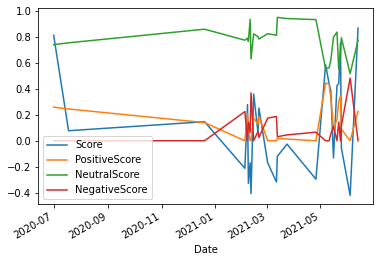

In [13]:
df.plot()